In [27]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

import torch
#from torch.utils.data import Dataset, DataLoader
#from torchvision import transforms
import pandas as pd
from PIL import Image
#import torch.nn as nn
#import torch.nn.functional as F

#import torch.optim as optim
#from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [28]:
submission = pd.read_csv(r'E:\Image Processings\sample_submission.csv')
test_data = pd.read_csv(r'E:\Image Processings\test.csv')
train_data = pd.read_csv(r'E:\Image Processings\train.csv')
target_name = pd.read_csv(r'E:\Image Processings\target_name_meta.tsv', delimiter='\t')

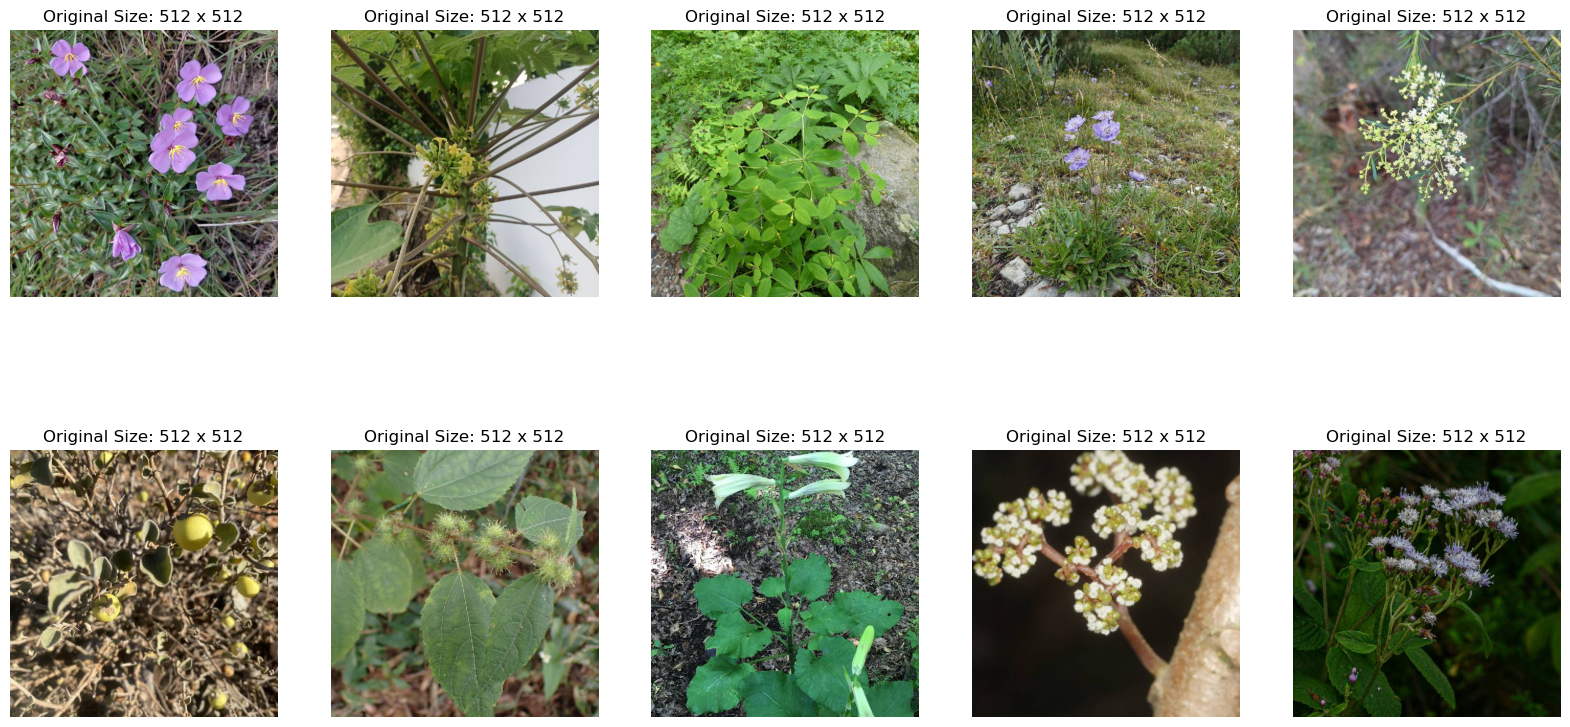

In [30]:
images_folder = r'E:\Image Processings\train_images'
image_files = os.listdir(images_folder)
random_images = random.sample(image_files, 10)

plt.figure(figsize=(20, 10))

for i, image_file in enumerate(random_images):
    plt.subplot(2, 5, i+1)
    image_path = os.path.join(images_folder, image_file)
    img = Image.open(image_path)

    original_size = img.size
    plt.imshow(img)

    plt.title(f"Original Size: {original_size[0]} x {original_size[1]}")
    plt.axis('off')
    
plt.show()

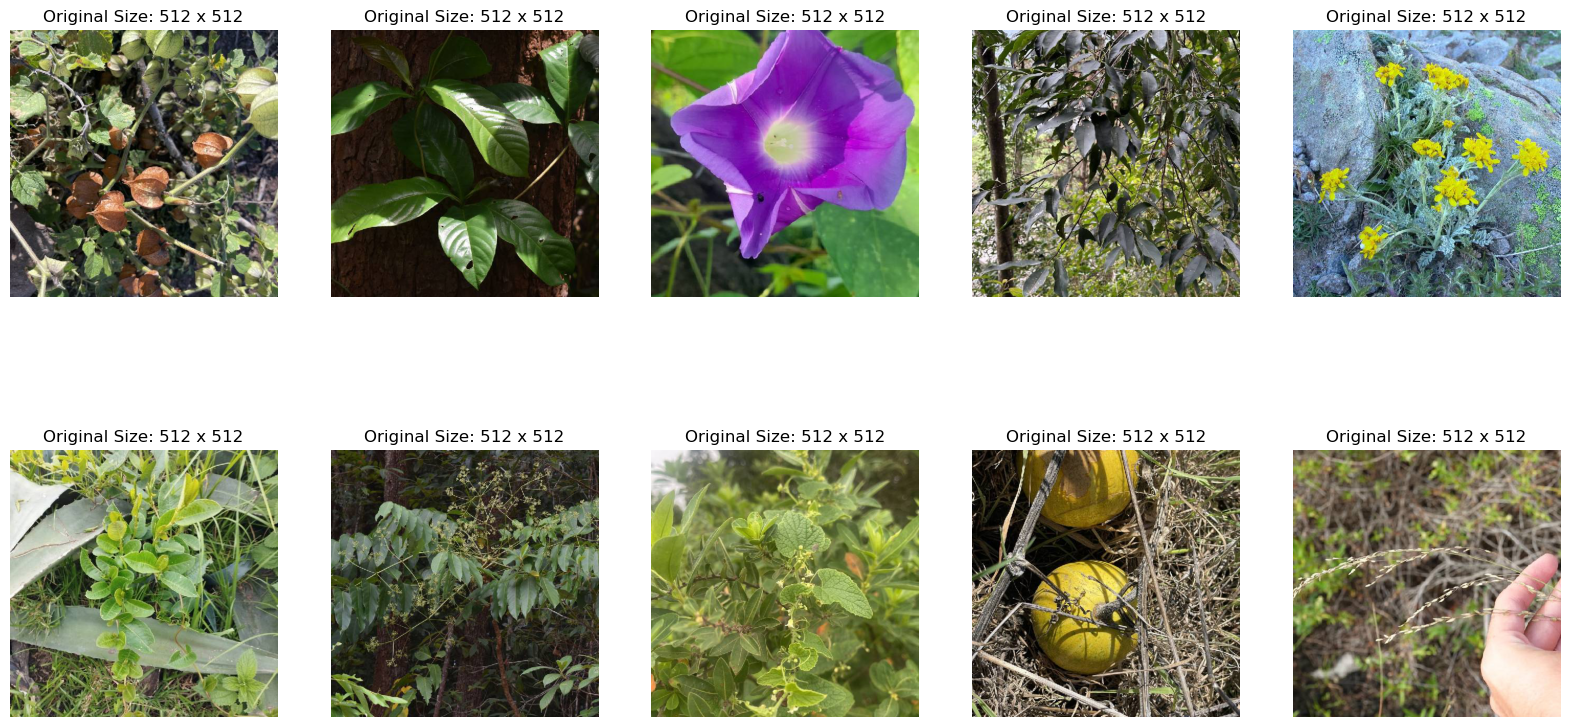

In [32]:
test_images_folder = r'E:\Image Processings\test_images'
image_files = os.listdir(test_images_folder)
random_images = random.sample(image_files, 10)

plt.figure(figsize=(20, 10))

for i, image_file in enumerate(random_images):
    plt.subplot(2, 5, i+1)
    image_path = os.path.join(test_images_folder, image_file)
    img = Image.open(image_path)

    original_size = img.size
    plt.imshow(img)

    plt.title(f"Original Size: {original_size[0]} x {original_size[1]}")
    plt.axis('off')
    
plt.show()

In [33]:
import numpy as np
def R2_Function(y_true,y_pred):
    ss_res = np.sum((y_true-y_pred)**2,axis=0)
    ss_total = np.sum((y_true-np.mean(y_true,axis=0))**2,axis=0)
    
    r2 = 1 - ss_res/(ss_total+1e-6)
    
    mean_r2 = np.mean(r2)
    
    
    return mean_r2

In [34]:
y_true_columns = train_data.filter(like='_mean').values

In [39]:
y_columns = [col for col in train_data.columns if col.endswith('_mean')]
X_columns = [col for col in train_data.columns if not col.endswith(('_sd', '_mean'))]

y = train_data[y_columns]
X = train_data[X_columns].drop(['id'], axis = 1)

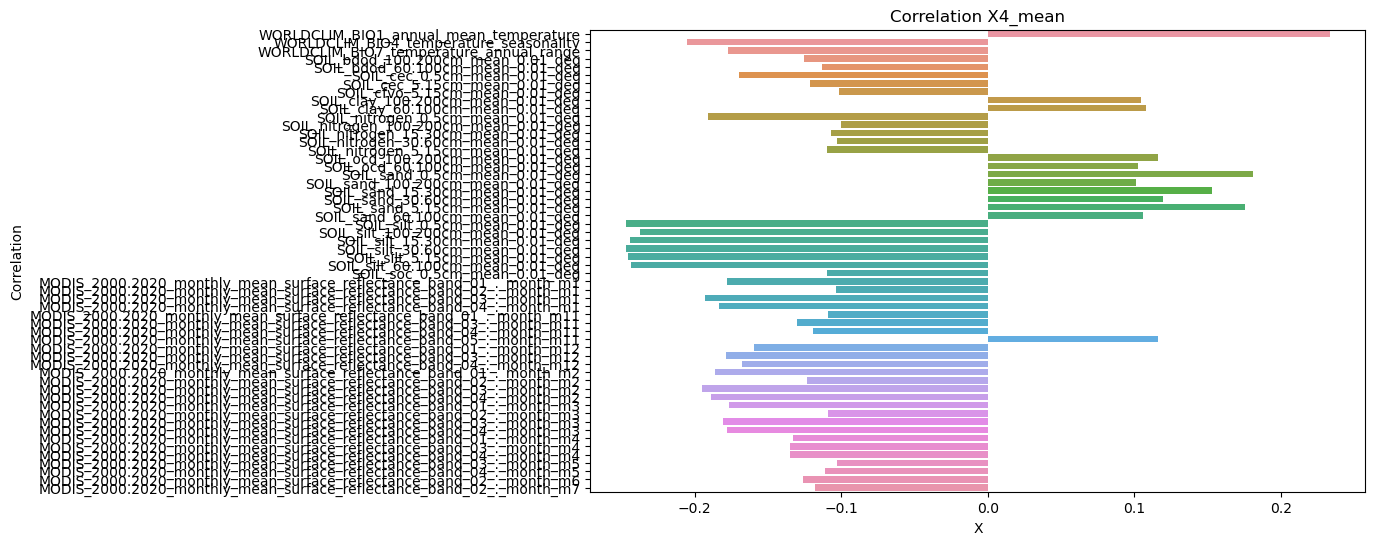

No correlation greater than 0.1 for X11_mean
No correlation greater than 0.1 for X18_mean
No correlation greater than 0.1 for X26_mean
No correlation greater than 0.1 for X50_mean
No correlation greater than 0.1 for X3112_mean


In [40]:
for target_col in y_columns:
    target = y[target_col]
    
    corr_matrix = X.corrwith(target)
    
    relevant_features = corr_matrix[abs(corr_matrix) >= 0.1]
    
    if len(relevant_features) == 0:
        print("No correlation greater than 0.1 for", target_col)
    else:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=relevant_features.values, y=relevant_features.index, orient='h')
        plt.title(f'Correlation {target_col}')
        plt.xlabel('X')
        plt.ylabel('Correlation')
        plt.show()

In [41]:
for target_col in y_columns:
    print(f"Selecting top 10 features for target column: {target_col}")
    
    selector = SelectKBest(score_func=f_regression, k=10)
    X_selected = selector.fit_transform(X, y[target_col])

    selected_indices = selector.get_support(indices=True)
    
    selected_features = X.columns[selected_indices]
    print("Selected features:", selected_features)
    print()

Selecting top 10 features for target column: X4_mean
Selected features: Index(['WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'SOIL_silt_0.5cm_mean_0.01_deg', 'SOIL_silt_100.200cm_mean_0.01_deg',
       'SOIL_silt_15.30cm_mean_0.01_deg', 'SOIL_silt_30.60cm_mean_0.01_deg',
       'SOIL_silt_5.15cm_mean_0.01_deg', 'SOIL_silt_60.100cm_mean_0.01_deg',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2'],
      dtype='object')

Selecting top 10 features for target column: X11_mean
Selected features: Index(['SOIL_bdod_0.5cm_mean_0.01_deg', 'SOIL_cec_0.5cm_mean_0.01_deg',
       'SOIL_ocd_0.5cm_mean_0.01_deg', 'SOIL_sand_0.5cm_mean_0.01_deg',
       'SOIL_silt_0.5cm_mean_0.01_deg', 'SOIL_silt_100.200cm_mean_0.01_deg',
       'SOIL_silt_15.30cm_mean_0.01_deg', 'SOIL_silt_30.60cm_mean_0.01_deg',
       'SOIL_silt_5.15cm_mean_0.01_deg', 'SOIL_s

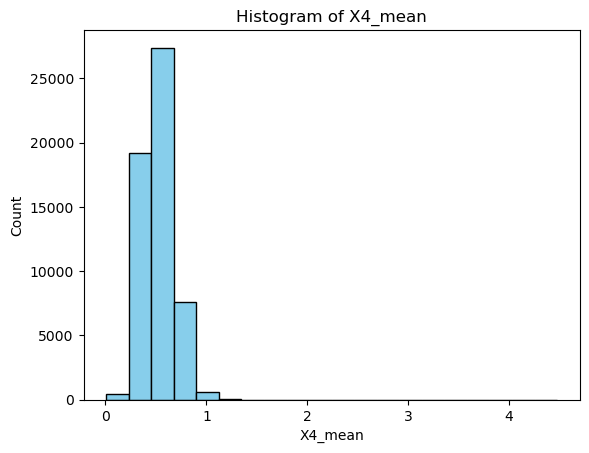

In [42]:
y_processed = y.drop(y[y['X4_mean'] < 0].index)

plt.hist(y_processed['X4_mean'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('X4_mean')
plt.ylabel('Count')
plt.title('Histogram of X4_mean')
plt.show()

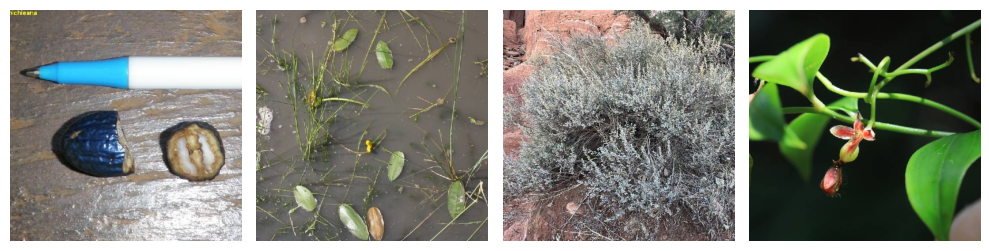

In [45]:
num_images_per_row = 4
filtered_data = train_data[train_data['X11_mean'] > 500]

fig, axes = plt.subplots(1, num_images_per_row, figsize=(10,3))

ids = filtered_data['id']

base_path = r'E:\Image Processings\train_images'

for i, id_value in enumerate(ids):
    image_path = os.path.join(base_path, f"{id_value}.jpeg")
    
    image = plt.imread(image_path)
    axes[i % num_images_per_row].imshow(image)
    axes[i % num_images_per_row].axis('off')

plt.tight_layout()
plt.show()

In [46]:
cols = X.columns.tolist()

first_two_words = ['_'.join(col.split('_')[:2]) for col in cols]

sorted_cols = {}

for col,first_two_word in zip(cols,first_two_words):
    if first_two_word not in sorted_cols:
        sorted_cols[first_two_word]=[col]
        
    else:
        sorted_cols[first_two_word].append(col)
        
        
for first_two_word,cols in sorted(sorted_cols.items()):
    print(f'{first_two_word}:')
    for col in cols:
        print(f'  -{col}')

MODIS_2000.2020:
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11
  -MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11
  -MODIS_2000.2020_monthly_mean_surface_reflectance_

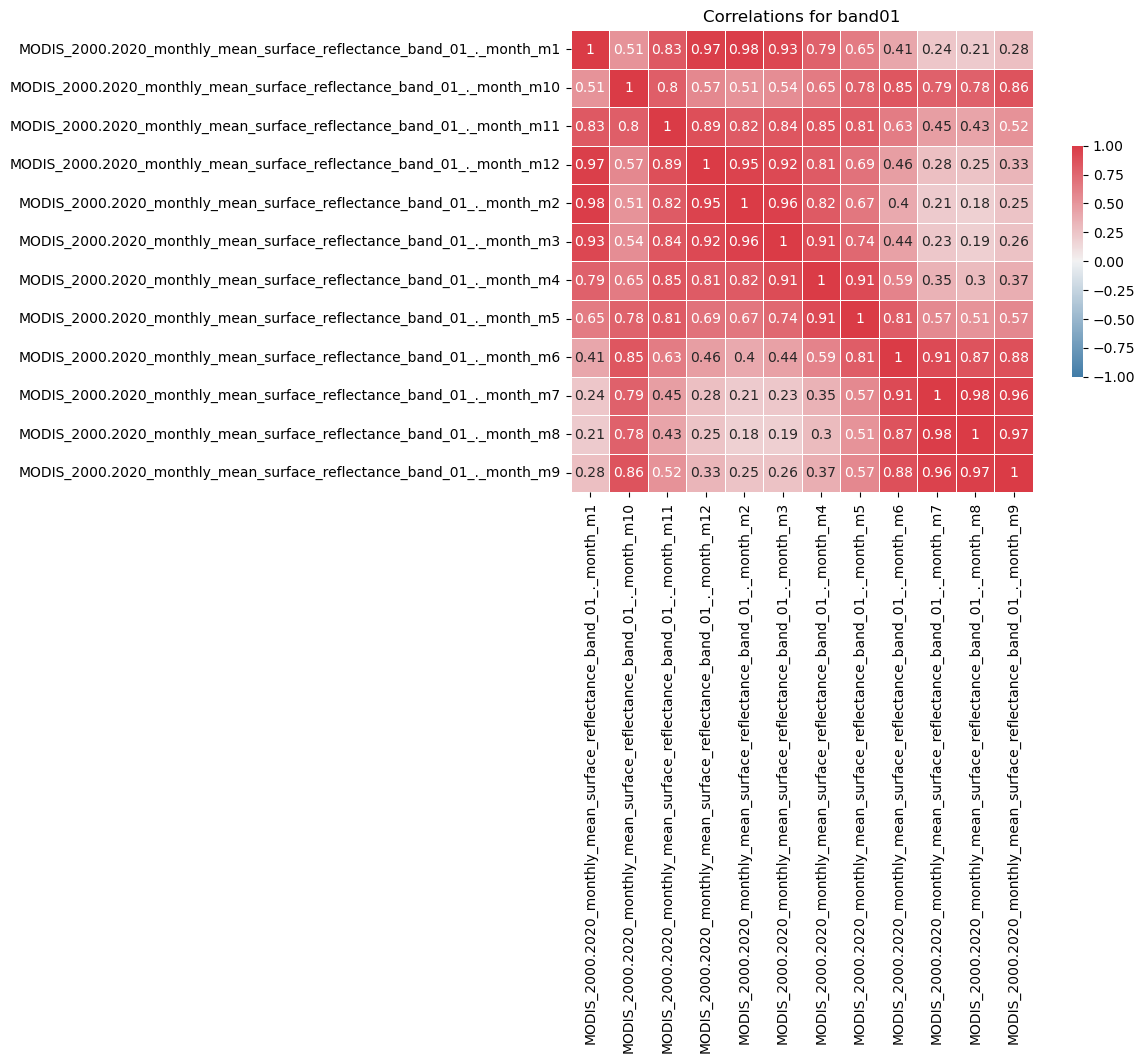

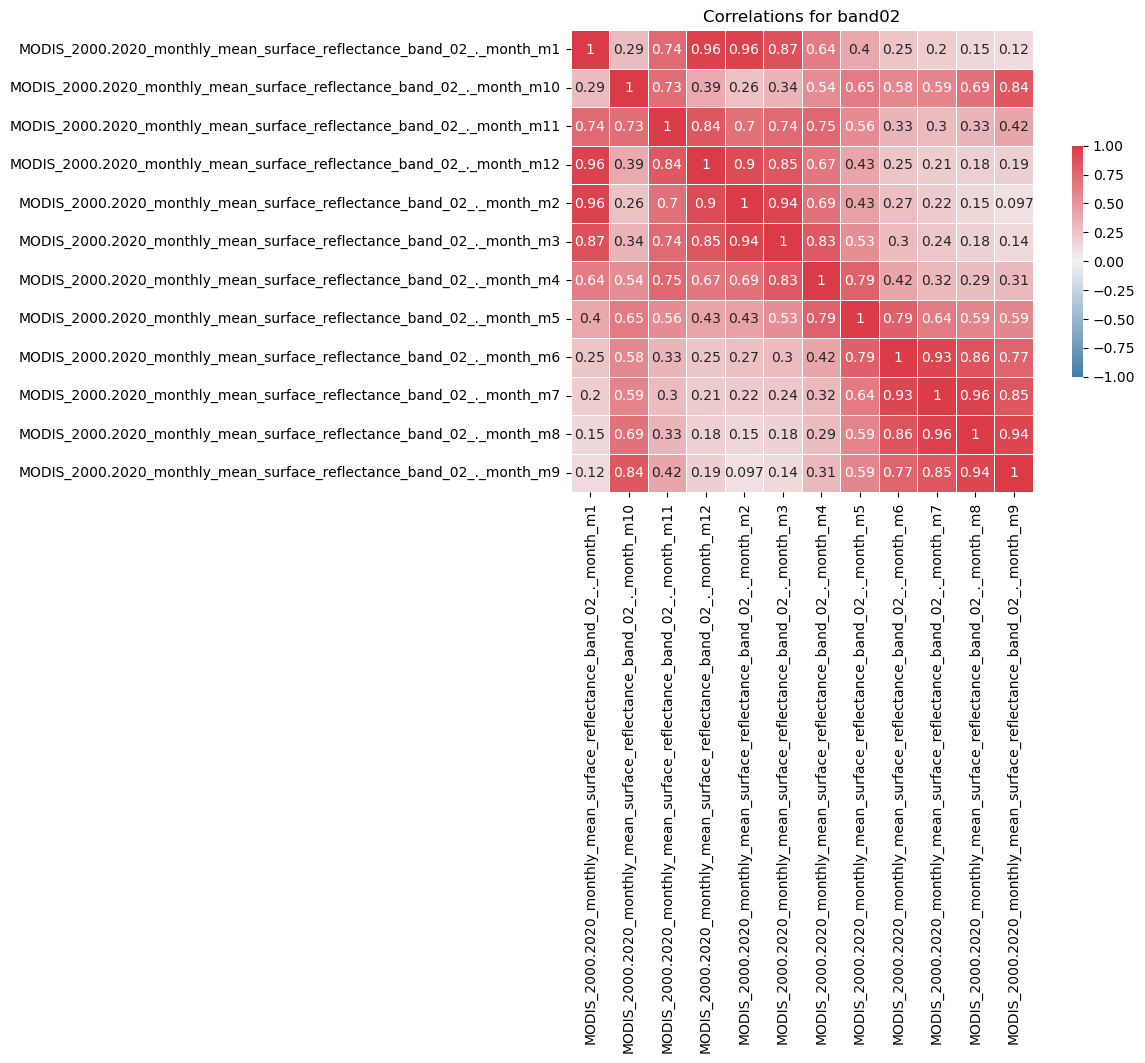

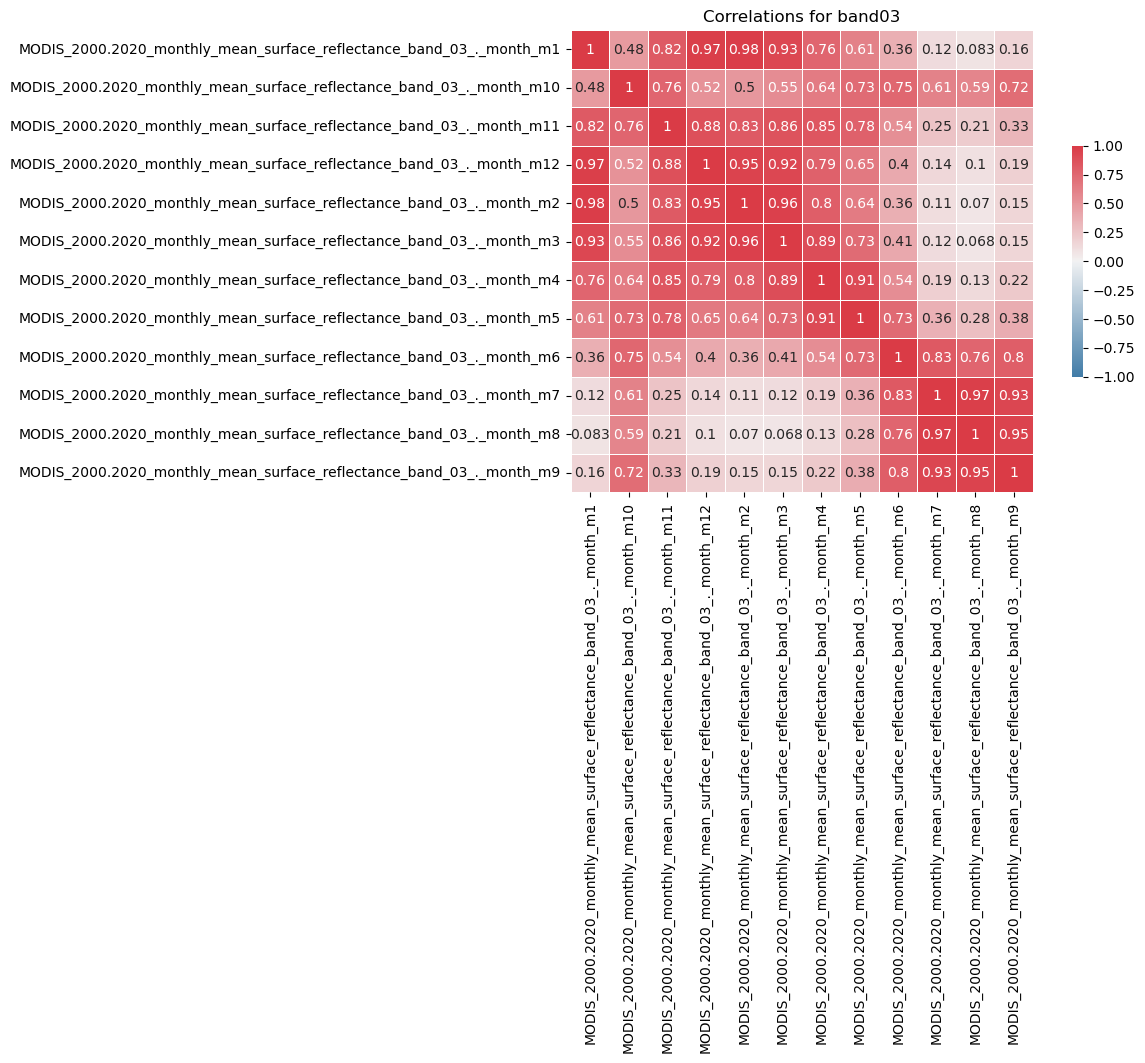

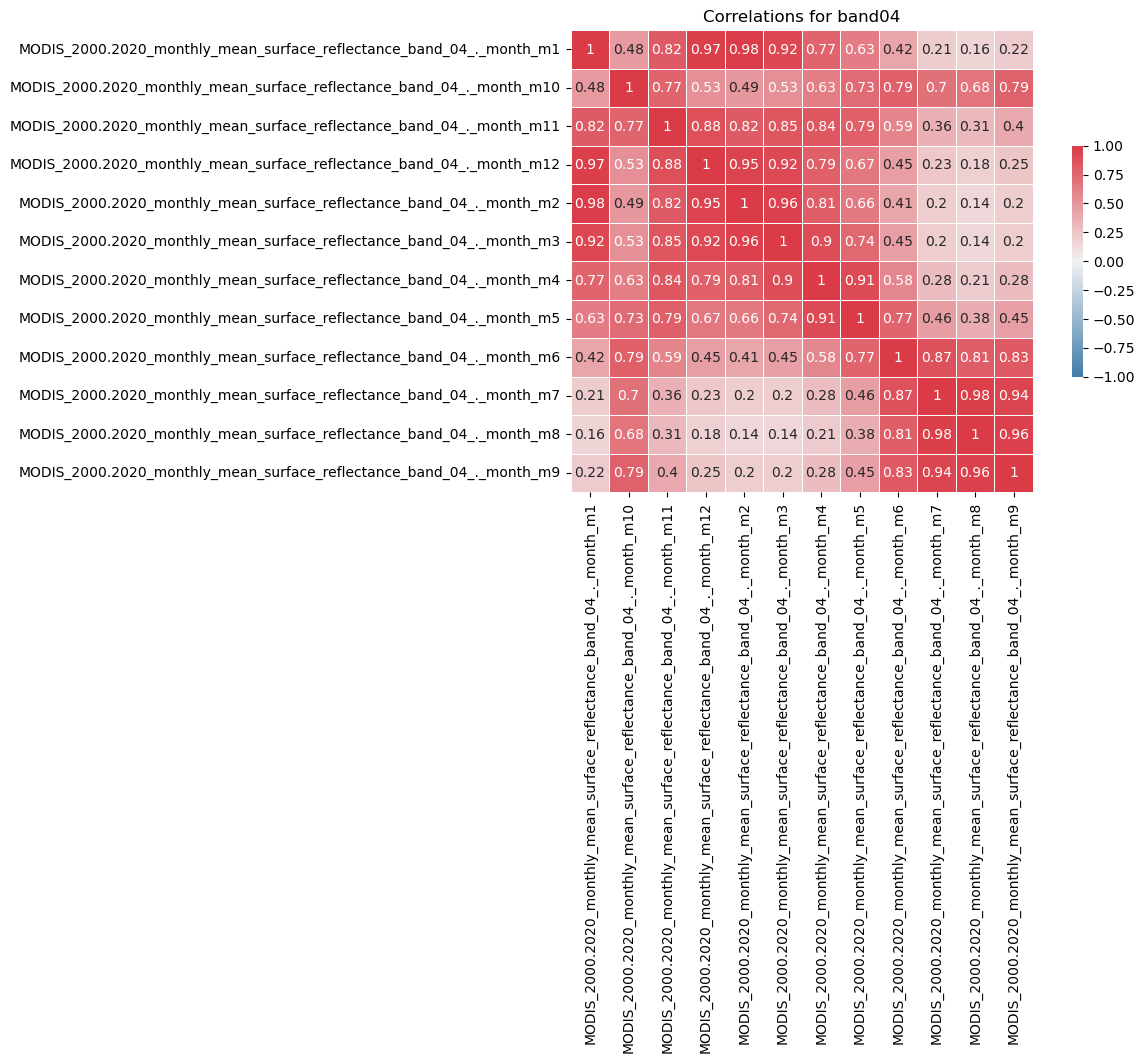

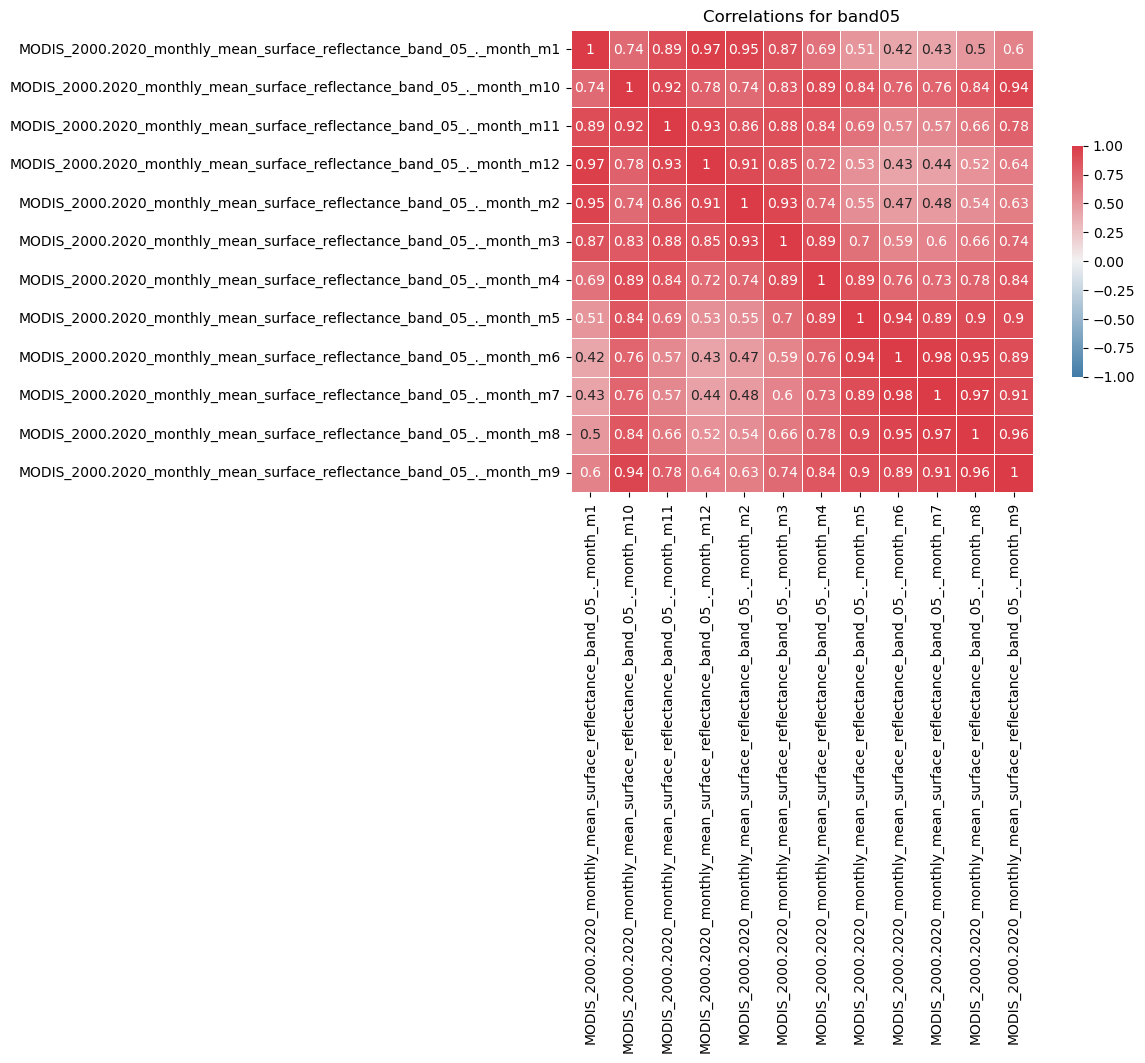

In [48]:
groups = {
    "band01": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_" in col],
    "band02": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_" in col],
    "band03": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_" in col],
    "band04": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_" in col],
    "band05": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_" in col],
}


for group_name, group_cols in groups.items():
    corr_matrix = X[group_cols].corr(method='pearson')
    mask = (corr_matrix.abs()>0.7)

    
    plt.figure(figsize=(10, 6))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
    plt.title(f"Correlations for {group_name}")
    plt.show()

In [50]:
filtered_columns = {key: val for key, val in sorted_cols.items() if 1 < len(val) <= 30}

for group_name, group_columns in filtered_columns.items():
    X[f'{group_name}_mean_features'] = X[group_columns].mean(axis=1)

In [51]:
for month, cols in groups.items():
    X_group = X[cols]
    scaler = StandardScaler()
    X_group_normalized = scaler.fit_transform(X_group)

    pca = PCA(n_components=1)
    X_group_pca = pca.fit_transform(X_group_normalized)
    X_group_pca = pd.DataFrame(X_group_pca, columns=[f'{month}_PCA_features'])

    X = pd.concat([X, X_group_pca], axis=1)

In [52]:
desired_columns = [
    'WORLDCLIM_BIO1_annual_mean_temperature',
    'WORLDCLIM_BIO12_annual_precipitation',
    'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
    'WORLDCLIM_BIO15_precipitation_seasonality',
    'WORLDCLIM_BIO4_temperature_seasonality'
]

features_columns = [col for col in X.columns if col.endswith('_features')]


selected_columns = desired_columns + features_columns

X = X[selected_columns]

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)

In [56]:
pip install torch torchvision


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [61]:
%pip uninstall torch torchvision




^C
Note: you may need to restart the kernel to use updated packages.


In [63]:
%load_ext autoreload
%autoreload 2

In [64]:
import torch
print(torch.__version__)


AttributeError: module 'torch' has no attribute '__version__'

In [54]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

ModuleNotFoundError: No module named 'torch._C'

In [49]:
class R2Loss(torch.nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, y_true, y_pred):
        SS_res = torch.sum((y_true - y_pred)**2, axis=0)
        SS_tot = torch.sum((y_true - torch.mean(y_true, axis=0))**2, axis=0)
        r2_loss = SS_res / (SS_tot + 1e-6)
        return torch.mean(r2_loss)
    
class R2Metric(torch.nn.Module):
    def __init__(self):
        super(R2Metric, self).__init__()
        self.SS_res = torch.zeros(6).to(device)
        self.SS_tot = torch.zeros(6).to(device)
        self.num_samples = torch.zeros(6).to(device)

    def update_state(self, y_true, y_pred):
        SS_res = torch.sum((y_true - y_pred)**2, axis=0)
        SS_tot = torch.sum((y_true - torch.mean(y_true, axis=0))**2, axis=0)
        self.SS_res += SS_res
        self.SS_tot += SS_tot
        self.num_samples += y_true.shape[0]

    def forward(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return torch.mean(r2)
    
    def reset_states(self):
        self.SS_res = torch.zeros(6).to(device)
        self.SS_tot = torch.zeros(6).to(device)
        self.num_samples = torch.zeros(6).to(device)

AttributeError: module 'torch' has no attribute 'nn'